In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [179]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
import os
import torch
from torch import nn
import cv2 as cv
from tqdm import tqdm
import shutil
import random
import math
import seaborn as sns

In [29]:
!nvidia-smi

Mon Jan 16 05:28:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
dir = "/kaggle/input/fruit81"

In [31]:
!pwd

/kaggle/input


In [32]:
%cd dir

[Errno 2] No such file or directory: 'dir'
/kaggle/input


In [33]:
%cd fruit81

/kaggle/input/fruit81


In [57]:
!pwd

/kaggle/input/fruit81/fruit81_full/fruit81_full


In [56]:
dataset_path = 'fruit81_full/fruit81_full'
os.chdir(dataset_path)# 进入到指定路径
print(os.listdir())# 输出路径下的列表名称

['腰果', '石榴', '黄桃', '柚子', '樱桃', '粑粑柑', '羊角蜜', '甘蔗', '李子', '杨桃', '沃柑', '砂糖橘', '香蕉', '木瓜', '血橙', '枣', '西梅', '番石榴-红', '沙棘', '蓝莓', '白萝卜', '胡萝卜', '蛇皮果', '山楂', '草莓', '菠萝莓', '沙果', '柿子', '甜瓜-伊丽莎白', '甜瓜-绿', '红心火龙果', '水蜜桃', '榴莲', '莲雾', '树莓', '西红柿', '无花果', '西柚', '荔枝', '山竹', '柠檬', '黑莓', '白兰瓜', '青苹果', '车厘子', '菠萝', '毛丹', '杏', '葡萄-白', '芒果', '酸角', '菠萝蜜', '圣女果', '红苹果', '白心火龙果', '梨', '甜瓜-金', '桑葚', '佛手瓜', '哈密瓜', '百香果', '猕猴桃', '芦柑', '桂圆', '西瓜', '香橼', '羊奶果', '橘子', '甜瓜-白', '杨梅', '椰子', '番石榴-百', '蟠桃', '金桔', '脐橙', '葡萄-红', '青柠', '枇杷', '油桃', '人参果', '牛油果']


In [58]:
# 在python中我们可以使用pandas来完成类似excel的功能，并且由于是代码控制，我们的结果会更加精准可控
df = pd.DataFrame()
for fruit in tqdm(os.listdir()): # 遍历每个类别    
    os.chdir(fruit)
    for file in os.listdir(): # 遍历每张图像
        try:
            img = cv.imread(file)
            df = df.append({'类别':fruit, '文件名':file, '图像宽':img.shape[1], '图像高':img.shape[0]}, ignore_index=True)
        except:
            print(os.path.join(fruit, file), '读取错误')
    os.chdir('../')
os.chdir('../')

100%|██████████| 81/81 [02:07<00:00,  1.58s/it]


In [59]:
df

,类别,文件名,图像宽,图像高
0,腰果,56.jpg,673.0,500.0
1,腰果,89.jpg,500.0,375.0
2,腰果,20.jpg,439.0,329.0
3,腰果,58.jpg,500.0,500.0
4,腰果,150.jpg,500.0,753.0
...,...,...,...,...
14428,牛油果,133.jpg,683.0,456.0
14429,牛油果,134.jpg,529.0,374.0
14430,牛油果,136.jpg,650.0,420.0
14431,牛油果,25.jpg,500.0,500.0


In [62]:
df.head(10)

,类别,文件名,图像宽,图像高
0,腰果,56.jpg,673.0,500.0
1,腰果,89.jpg,500.0,375.0
2,腰果,20.jpg,439.0,329.0
3,腰果,58.jpg,500.0,500.0
4,腰果,150.jpg,500.0,753.0
5,腰果,6.jpg,500.0,500.0
6,腰果,109.jpg,750.0,500.0
7,腰果,149.jpg,500.0,333.0
8,腰果,187.jpg,500.0,500.0
9,腰果,76.jpg,500.0,500.0


可视化图像尺寸分布

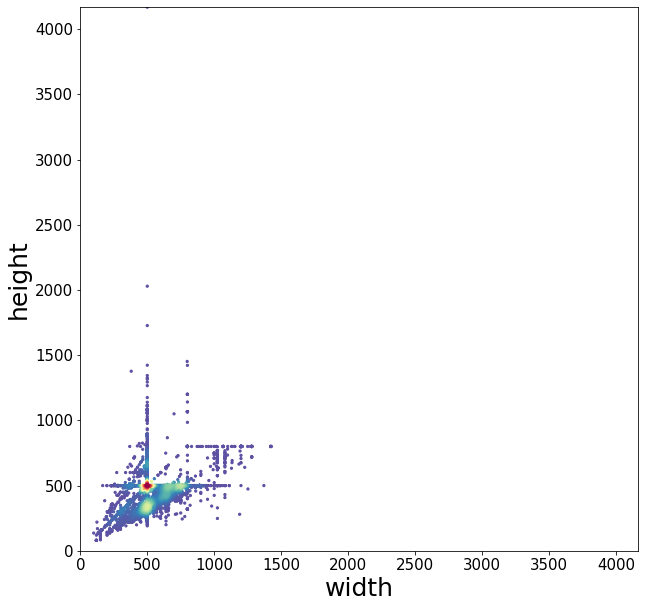

In [64]:
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

x = df['图像宽']
y = df['图像高']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(10,10))
# plt.figure(figsize=(12,12))
plt.scatter(x, y, c=z,  s=5, cmap='Spectral_r')
# plt.colorbar()
# plt.xticks([])
# plt.yticks([])

plt.tick_params(labelsize=15)

xy_max = max(max(df['图像宽']), max(df['图像高']))
plt.xlim(xmin=0, xmax=xy_max)
plt.ylim(ymin=0, ymax=xy_max)

plt.ylabel('height', fontsize=25)
plt.xlabel('width', fontsize=25)

# plt.savefig('图像尺寸分布.pdf', dpi=120, bbox_inches='tight')

plt.show()

In [102]:
dataset_name = dataset_path.split('_')[0]
print('数据集', dataset_name)

数据集 fruit81


In [70]:
%cd ../

/kaggle/input/fruit81


In [105]:
!pwd

/kaggle/input/fruit81


In [106]:
dataset_path_new = "../../working/save"
classes = os.listdir(dataset_path)
len(classes)

81

In [107]:
# 创建 train 文件夹
os.mkdir(os.path.join(dataset_path_new, 'train'))

# 创建 test 文件夹
os.mkdir(os.path.join(dataset_path_new, 'val'))

# 在 train 和 test 文件夹中创建各类别子文件夹
for fruit in classes:
    os.mkdir(os.path.join(dataset_path_new, 'train', fruit))
    os.mkdir(os.path.join(dataset_path_new, 'val', fruit))

In [108]:
!pwd

/kaggle/input/fruit81


划分训练集、测试集、移动文件

In [112]:
test_frac = 0.2  # 测试集比例
random.seed(123) # 随机数种子，便于复现

In [121]:
df = pd.DataFrame()

print('{:^18} {:^18} {:^18}'.format('类别', '训练集数据个数', '测试集数据个数'))

for fruit in classes: # 遍历每个类别

    # 读取该类别的所有图像文件名
    old_dir = os.path.join(dataset_path, fruit)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # 随机打乱

    # 划分训练集和测试集
    testset_numer = int(len(images_filename) * test_frac) # 测试集图像个数
    testset_images = images_filename[:testset_numer]      # 获取拟移动至 test 目录的测试集图像文件名
    trainset_images = images_filename[testset_numer:]     # 获取拟移动至 train 目录的训练集图像文件名

    # 移动图像至 test 目录
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, fruit, image)         # 获取原始文件路径
        new_test_path = os.path.join(dataset_path_new, 'val', fruit, image) # 获取 test 目录的新文件路径
        shutil.move(old_img_path, new_test_path) # 移动文件

    # 移动图像至 train 目录
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, fruit, image)           # 获取原始文件路径
        new_train_path = os.path.join(dataset_path_new, 'train', fruit, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_train_path) # 移动文件

    # 删除旧文件夹
    # assert len(os.listdir(old_dir)) == 0 # 确保旧文件夹中的所有图像都被移动走
    # shutil.rmtree(old_dir) # 删除文件夹
    
    # 工整地输出每一类别的数据个数
    print('{:^18} {:^18} {:^18}'.format(fruit, len(trainset_images), len(testset_images)))
    # 保存到表格中
    df = df.append({'class':fruit, 'trainset':len(trainset_images), 'testset':len(testset_images)}, ignore_index=True)

# 重命名数据集文件夹
#shutil.move(dataset_path_new, dataset_name+'_split')

# 数据集各类别数量统计表格，导出为 csv 文件
df['total'] = df['trainset'] + df['testset']
df.to_csv('数据量统计.csv', index=False)

        类别              训练集数据个数            测试集数据个数      


OSError: [Errno 30] Read-only file system: 'fruit81_full/fruit81_full/腰果/158.png'

In [123]:
%cd ../../working

/kaggle/working


In [124]:
%mkdir classify

In [125]:
!ls

__notebook_source__.ipynb  classify  save


In [126]:
%cd classify

/kaggle/working/classify


In [127]:
# 下载压缩包
# 如报错 Unable to establish SSL connection. 重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit81/fruit81_full.zip

--2023-01-16 06:12:20--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit81/fruit81_full.zip
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724936499 (691M) [application/zip]
Saving to: ‘fruit81_full.zip’

fruit81_full.zip    100%[===================>] 691.35M  10.1MB/s    in 73s     

2023-01-16 06:13:35 (9.51 MB/s) - ‘fruit81_full.zip’ saved [724936499/724936499]



In [128]:
!ls

fruit81_full.zip


In [129]:
# 解压
!unzip fruit81_full.zip >> /dev/null

In [130]:
!ls

fruit81_full  fruit81_full.zip


In [133]:
# 指定数据集路径
dataset_path = 'fruit81_full'

In [138]:
dataset_name = dataset_path.split('_')[0]
print('数据集', dataset_name)

数据集 fruit81


In [139]:
classes = os.listdir(dataset_path)
len(classes)

81

In [140]:
classes

['杨梅',
 '黑莓',
 '甜瓜-绿',
 '西瓜',
 '榴莲',
 '荔枝',
 '芒果',
 '杏',
 '菠萝',
 '白兰瓜',
 '牛油果',
 '人参果',
 '芦柑',
 '金桔',
 '葡萄-白',
 '红苹果',
 '油桃',
 '山楂',
 '红心火龙果',
 '西柚',
 '草莓',
 '腰果',
 '杨桃',
 '李子',
 '羊奶果',
 '沙果',
 '树莓',
 '甜瓜-伊丽莎白',
 '哈密瓜',
 '佛手瓜',
 '柠檬',
 '香蕉',
 '石榴',
 '甜瓜-白',
 '桑葚',
 '百香果',
 '血橙',
 '蛇皮果',
 '车厘子',
 '枇杷',
 '圣女果',
 '无花果',
 '木瓜',
 '桂圆',
 '胡萝卜',
 '青苹果',
 '番石榴-红',
 '脐橙',
 '莲雾',
 '樱桃',
 '枣',
 '西梅',
 '甜瓜-金',
 '山竹',
 '沃柑',
 '毛丹',
 '白萝卜',
 '白心火龙果',
 '柚子',
 '西红柿',
 '梨',
 '甘蔗',
 '椰子',
 '番石榴-百',
 '砂糖橘',
 '葡萄-红',
 '柿子',
 '水蜜桃',
 '猕猴桃',
 '菠萝蜜',
 '蟠桃',
 '酸角',
 '羊角蜜',
 '香橼',
 '沙棘',
 '粑粑柑',
 '菠萝莓',
 '黄桃',
 '青柠',
 '橘子',
 '蓝莓']

In [141]:
# 创建 train 文件夹
os.mkdir(os.path.join(dataset_path, 'train'))

# 创建 test 文件夹
os.mkdir(os.path.join(dataset_path, 'val'))

# 在 train 和 test 文件夹中创建各类别子文件夹
for fruit in classes:
    os.mkdir(os.path.join(dataset_path, 'train', fruit))
    os.mkdir(os.path.join(dataset_path, 'val', fruit))

In [142]:
test_frac = 0.2  # 测试集比例
random.seed(123) # 随机数种子，便于复现

In [143]:
df = pd.DataFrame()

print('{:^18} {:^18} {:^18}'.format('类别', '训练集数据个数', '测试集数据个数'))

for fruit in classes: # 遍历每个类别

    # 读取该类别的所有图像文件名
    old_dir = os.path.join(dataset_path, fruit)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # 随机打乱

    # 划分训练集和测试集
    testset_numer = int(len(images_filename) * test_frac) # 测试集图像个数
    testset_images = images_filename[:testset_numer]      # 获取拟移动至 test 目录的测试集图像文件名
    trainset_images = images_filename[testset_numer:]     # 获取拟移动至 train 目录的训练集图像文件名

    # 移动图像至 test 目录
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, fruit, image)         # 获取原始文件路径
        new_test_path = os.path.join(dataset_path, 'val', fruit, image) # 获取 test 目录的新文件路径
        shutil.move(old_img_path, new_test_path) # 移动文件

    # 移动图像至 train 目录
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, fruit, image)           # 获取原始文件路径
        new_train_path = os.path.join(dataset_path, 'train', fruit, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_train_path) # 移动文件
    
    # 删除旧文件夹
    assert len(os.listdir(old_dir)) == 0 # 确保旧文件夹中的所有图像都被移动走
    shutil.rmtree(old_dir) # 删除文件夹
    
    # 工整地输出每一类别的数据个数
    print('{:^18} {:^18} {:^18}'.format(fruit, len(trainset_images), len(testset_images)))
    
    # 保存到表格中
    df = df.append({'class':fruit, 'trainset':len(trainset_images), 'testset':len(testset_images)}, ignore_index=True)

# 重命名数据集文件夹
shutil.move(dataset_path, dataset_name+'_split')

# 数据集各类别数量统计表格，导出为 csv 文件
df['total'] = df['trainset'] + df['testset']
df.to_csv('数据量统计.csv', index=False)

        类别              训练集数据个数            测试集数据个数      
        杨梅                153                 38        
        黑莓                150                 37        
       甜瓜-绿                35                 8         
        西瓜                156                 38        
        榴莲                159                 39        
        荔枝                158                 39        
        芒果                139                 34        
        杏                 158                 39        
        菠萝                158                 39        
       白兰瓜                103                 25        
       牛油果                120                 30        
       人参果                146                 36        
        芦柑                146                 36        
        金桔                145                 36        
       葡萄-白               125                 31        
       红苹果                142                 35        
        油桃                160  

In [144]:
df

,class,trainset,testset,total
0,杨梅,153.0,38.0,191.0
1,黑莓,150.0,37.0,187.0
2,甜瓜-绿,35.0,8.0,43.0
3,西瓜,156.0,38.0,194.0
4,榴莲,159.0,39.0,198.0
...,...,...,...,...
76,菠萝莓,91.0,22.0,113.0
77,黄桃,155.0,38.0,193.0
78,青柠,119.0,29.0,148.0
79,橘子,145.0,36.0,181.0


In [145]:
!sudo snap install tree

sudo: snap: command not found


In [146]:
!tree fruit81_split -L 2

fruit81_split
├── train
│   ├── 人参果
│   ├── 佛手瓜
│   ├── 哈密瓜
│   ├── 圣女果
│   ├── 山楂
│   ├── 山竹
│   ├── 无花果
│   ├── 木瓜
│   ├── 李子
│   ├── 杏
│   ├── 杨桃
│   ├── 杨梅
│   ├── 枇杷
│   ├── 枣
│   ├── 柚子
│   ├── 柠檬
│   ├── 柿子
│   ├── 树莓
│   ├── 桂圆
│   ├── 桑葚
│   ├── 梨
│   ├── 椰子
│   ├── 榴莲
│   ├── 樱桃
│   ├── 橘子
│   ├── 毛丹
│   ├── 水蜜桃
│   ├── 沃柑
│   ├── 沙果
│   ├── 沙棘
│   ├── 油桃
│   ├── 牛油果
│   ├── 猕猴桃
│   ├── 甘蔗
│   ├── 甜瓜-伊丽莎白
│   ├── 甜瓜-白
│   ├── 甜瓜-绿
│   ├── 甜瓜-金
│   ├── 番石榴-百
│   ├── 番石榴-红
│   ├── 白兰瓜
│   ├── 白心火龙果
│   ├── 白萝卜
│   ├── 百香果
│   ├── 石榴
│   ├── 砂糖橘
│   ├── 粑粑柑
│   ├── 红心火龙果
│   ├── 红苹果
│   ├── 羊奶果
│   ├── 羊角蜜
│   ├── 胡萝卜
│   ├── 脐橙
│   ├── 腰果
│   ├── 芒果
│   ├── 芦柑
│   ├── 草莓
│   ├── 荔枝
│   ├── 莲雾
│   ├── 菠萝
│   ├── 菠萝莓
│   ├── 菠萝蜜
│   ├── 葡萄-白
│   ├── 葡萄-红
│   ├── 蓝莓
│   ├── 蛇皮果
│   ├── 蟠桃
│   ├── 血橙
│   ├── 西柚
│   ├── 西梅
│   ├── 西瓜
│   ├── 西红柿
│   ├── 车厘子
│   ├── 酸角
│   ├── 金桔
│   ├── 青柠
│   ├── 青苹果
│   ├── 香橼
│   ├── 香蕉
│   ├── 黄桃
│   └── 黑莓
└── val
    ├── 人参果
    ├── 佛手瓜
    ├─

In [147]:
folder_path = 'fruit81_split/train/西瓜'

In [148]:
# 可视化图像的个数
N = 36

In [151]:
# n 行 n 列
n = math.floor(np.sqrt(N))
n

6

In [154]:
images = []
for each_img in os.listdir(folder_path)[:N]:
    img_path = os.path.join(folder_path, each_img)
    img_bgr = cv.imread(img_path)
    img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
    images.append(img_rgb)

In [155]:
len(images)

36

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  del sys.path[0]


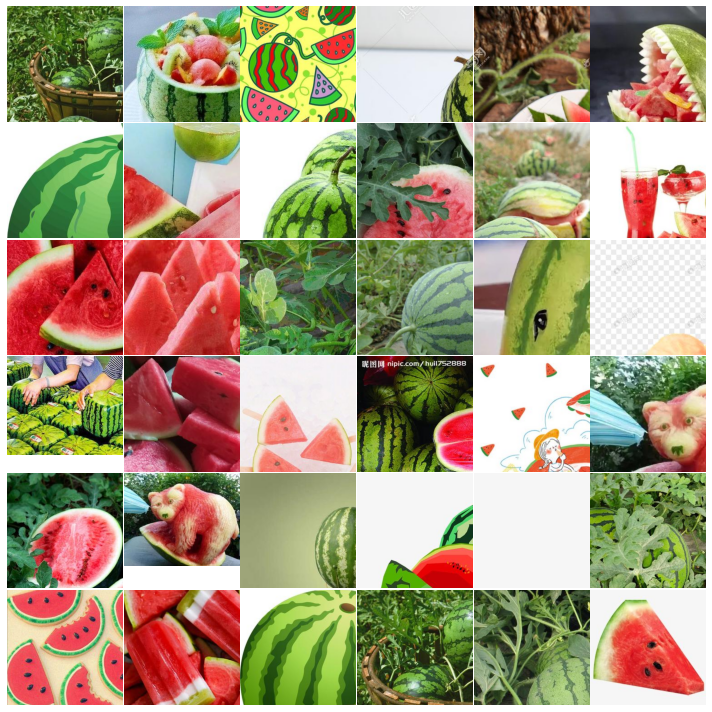

In [158]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # 类似绘制子图 subplot(111)
                 nrows_ncols=(n, n),  # 创建 n 行 m 列的 axes 网格
                 axes_pad=0.02,  # 网格间距
                 share_all=True
                 )

# 遍历每张图像
for ax, im in zip(grid, images):
    ax.imshow(im)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [184]:
!wget https://us-logger1.oss-cn-beijing.aliyuncs.com/SimHei.ttf

--2023-01-16 06:42:27--  https://us-logger1.oss-cn-beijing.aliyuncs.com/SimHei.ttf
Resolving us-logger1.oss-cn-beijing.aliyuncs.com (us-logger1.oss-cn-beijing.aliyuncs.com)... 59.110.190.23
Connecting to us-logger1.oss-cn-beijing.aliyuncs.com (us-logger1.oss-cn-beijing.aliyuncs.com)|59.110.190.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [font/ttf]
Saving to: ‘SimHei.ttf’

SimHei.ttf          100%[===================>]   9.30M  3.08MB/s    in 3.0s    

2023-01-16 06:42:31 (3.08 MB/s) - ‘SimHei.ttf’ saved [9751960/9751960]



In [185]:
pwd

'/kaggle/working/classify'

In [186]:
ls

SimHei.ttf        fruit81_split/      数据量统计.csv
fruit81_full.zip  各类别图像数量.pdf


In [189]:
from matplotlib.font_manager import FontProperties  
myfont=FontProperties(fname='./SimHei.ttf',size=14)  
sns.set(font=myfont.get_name()) 
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [190]:
df = pd.read_csv('数据量统计.csv')

In [191]:
df.shape

(81, 4)

In [192]:
df

,class,trainset,testset,total
0,杨梅,153.0,38.0,191.0
1,黑莓,150.0,37.0,187.0
2,甜瓜-绿,35.0,8.0,43.0
3,西瓜,156.0,38.0,194.0
4,榴莲,159.0,39.0,198.0
...,...,...,...,...
76,菠萝莓,91.0,22.0,113.0
77,黄桃,155.0,38.0,193.0
78,青柠,119.0,29.0,148.0
79,橘子,145.0,36.0,181.0


In [193]:
# 指定可视化的特征
feature = 'total'
# feature = 'trainset'
# feature = 'testset'

In [194]:
df = df.sort_values(by=feature, ascending=False)
df.head()

,class,trainset,testset,total
21,腰果,160.0,40.0,200.0
16,油桃,160.0,39.0,199.0
69,菠萝蜜,160.0,39.0,199.0
65,葡萄-红,160.0,39.0,199.0
56,白萝卜,160.0,39.0,199.0


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33136 (\N{CJK UNIFIED IDEOGRAPH-8170}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27833 (\N{CJK UNIFIED IDEOGRAPH-6CB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26691 (\N{CJK UNIFIED IDEOGRAPH-6843}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33760 (\N{CJK UNIFIED IDEOGRAPH-83E0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda

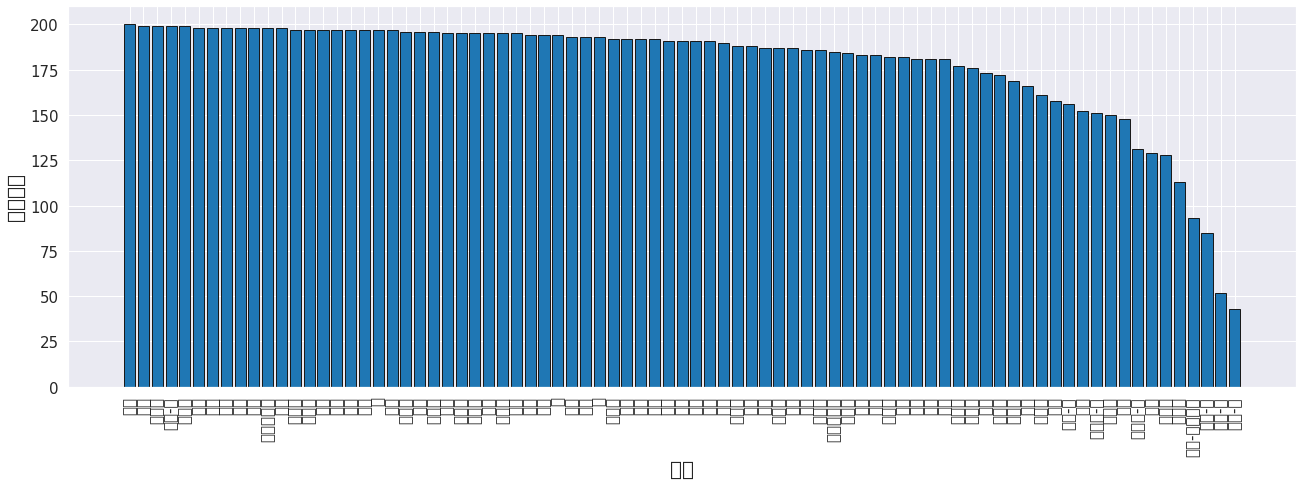

In [195]:
plt.figure(figsize=(22, 7))

x = df['class']
y = df[feature]

plt.bar(x, y, facecolor='#1f77b4', edgecolor='k')

plt.xticks(rotation=90)
plt.tick_params(labelsize=15)
plt.xlabel('类别', fontsize=20)
plt.ylabel('图像数量', fontsize=20)

# plt.savefig('各类别图片数量.pdf', dpi=120, bbox_inches='tight')

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Glyph 33136 (\N{CJK UNIFIED IDEOGRAPH-8170}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Glyph 27833 (\N{CJK UNIFIED IDEOGRAPH-6CB9}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Glyph 26691 (\N{CJK UNIFIED IDEOGRAPH-6843}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Glyph 33760 (\N{CJK UNIFIED IDEOGRAPH-83E0}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Glyph 33821 (\N{CJK UNIFIED IDEOGRAPH-841D}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Glyph 34588 (\N{CJK UN

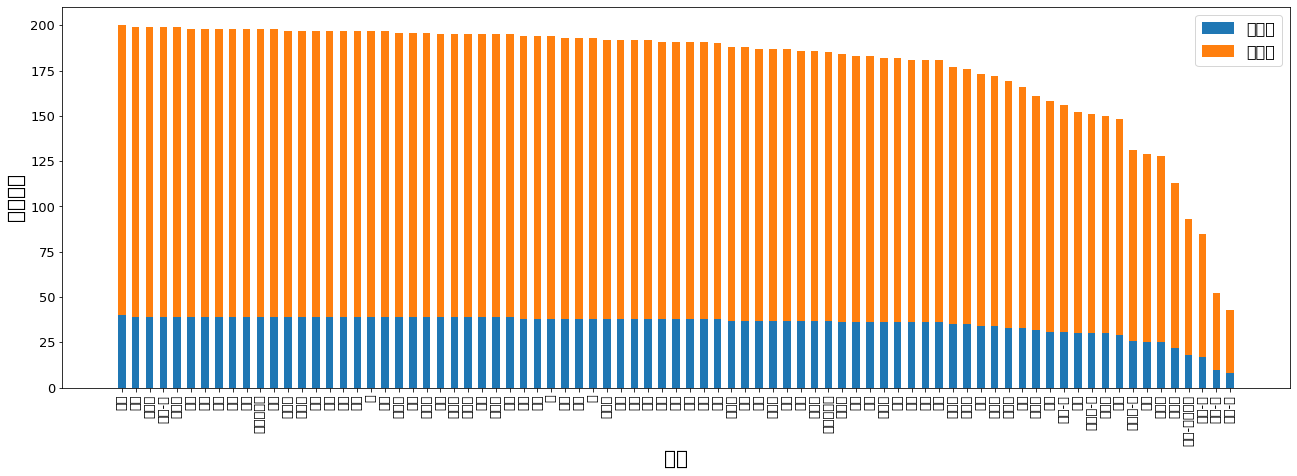

In [177]:
plt.figure(figsize=(22, 7))
x = df['class']
y1 = df['testset']
y2 = df['trainset']

width = 0.55 # 柱状图宽度

plt.xticks(rotation=90) # 横轴文字旋转

plt.bar(x, y1, width, label='测试集')
plt.bar(x, y2, width, label='训练集', bottom=y1)


plt.xlabel('类别', fontsize=20)
plt.ylabel('图像数量', fontsize=20)
plt.tick_params(labelsize=13) # 设置坐标文字大小

plt.legend(fontsize=16) # 图例

# 保存为高清的 pdf 文件
plt.savefig('各类别图像数量.pdf', dpi=120, bbox_inches='tight')

plt.show()